# Imports

In [1]:
import numpy as np
np.random.seed(1)
import tensorflow
tensorflow.set_random_seed(1)

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import os
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.optimizers import Nadam, Adam
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

Using TensorFlow backend.


In [4]:
if not os.path.exists('results'):
    os.makedirs('results')

# Dataset

In [5]:
train = pd.read_csv('../feature_engineering/train.gz')
X_train = train[train.columns[:-1]].values
X_train /= 20000
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
y_train = train[train.columns[-1]].values
y_train /= 1000

In [6]:
X_train.shape

(21161, 1, 11)

In [7]:
y_train.shape

(21161,)

In [8]:
test = pd.read_csv('../feature_engineering/test.gz')
X_test = test[test.columns[:-1]].values
X_test /= 20000
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
y_test = test[test.columns[-1]].values
y_test /= 1000

In [9]:
X_test.shape

(767, 1, 11)

In [10]:
y_test.shape

(767,)

# Architecture

In [11]:
def build_model(input_shape: tuple) -> Model:
    """
    Build and compile a neural model.

    Args:
        input_shape: the input shape for the network

    Returns:
        a compiled sequential model with given input shape

    """
    # clear the Keras session (only applies to keras models, but 
    # wont hurt sklearn ones to call this.
    K.clear_session()
    # create a sequential model with LSTM layers    
    model = Sequential([
        LSTM(100, input_shape=input_shape, return_sequences=True),
        LSTM(100, return_sequences=True),
        LSTM(100),
        Dense(1)
    ])
    # compile the model
    model.compile(
        loss='mean_squared_error', 
        optimizer=Adam(),
    )

    return model

In [12]:
model = build_model((X_train.shape[1], X_train.shape[2]))
model

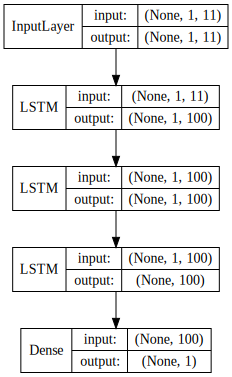

In [13]:
arch = model_to_dot(model, show_shapes=True, show_layer_names=False)
arch.write_pdf('results/lstm-arch.pdf')
SVG(arch.create(prog='dot', format='svg'))

# Experiment

In [14]:
history = model.fit(X_train, y_train, epochs=50, batch_size=1000, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 21161 samples, validate on 767 samples
Epoch 1/50
 - 2s - loss: 3.5028e-04 - val_loss: 1.6799e-04
Epoch 2/50
 - 1s - loss: 2.7034e-04 - val_loss: 1.6219e-04
Epoch 3/50
 - 1s - loss: 2.9097e-04 - val_loss: 1.5366e-04
Epoch 4/50
 - 1s - loss: 2.9126e-04 - val_loss: 1.4131e-04
Epoch 5/50
 - 1s - loss: 2.8592e-04 - val_loss: 1.3252e-04
Epoch 6/50
 - 1s - loss: 2.8358e-04 - val_loss: 1.2835e-04
Epoch 7/50
 - 1s - loss: 2.8572e-04 - val_loss: 1.2198e-04
Epoch 8/50
 - 1s - loss: 2.8691e-04 - val_loss: 1.1022e-04
Epoch 9/50
 - 1s - loss: 2.8258e-04 - val_loss: 9.8222e-05
Epoch 10/50
 - 1s - loss: 2.7670e-04 - val_loss: 9.0742e-05
Epoch 11/50
 - 1s - loss: 2.7307e-04 - val_loss: 8.5932e-05
Epoch 12/50
 - 1s - loss: 2.7134e-04 - val_loss: 8.1369e-05
Epoch 13/50
 - 1s - loss: 2.6889e-04 - val_loss: 7.6550e-05
Epoch 14/50
 - 1s - loss: 2.6571e-04 - val_loss: 7.2243e-05
Epoch 15/50
 - 1s - loss: 2.6303e-04 - val_loss: 6.8585e-05
Epoch 16/50
 - 1s - loss: 2.6132e-04 - val_loss: 6.5004e-05
E

In [15]:
results = pd.DataFrame([history.history['loss'], history.history['val_loss']], index=['train', 'validation']).T

Text(0.5,0,'Epoch')

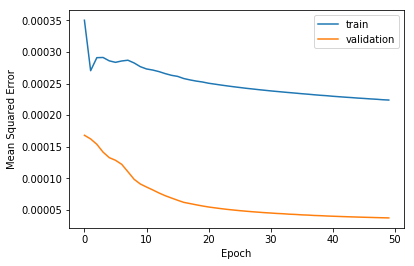

In [16]:
ax = results.plot()
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Epoch')

# Train Error

In [17]:
train_pred = model.predict(X_train).reshape(-1)

In [18]:
train_err = mean_squared_error(y_train * 1000, train_pred * 1000)
train_err

201.0461256539436

In [19]:
train_df = pd.DataFrame([y_train, train_pred], index=['Truth', 'Predictions']).T * 1000

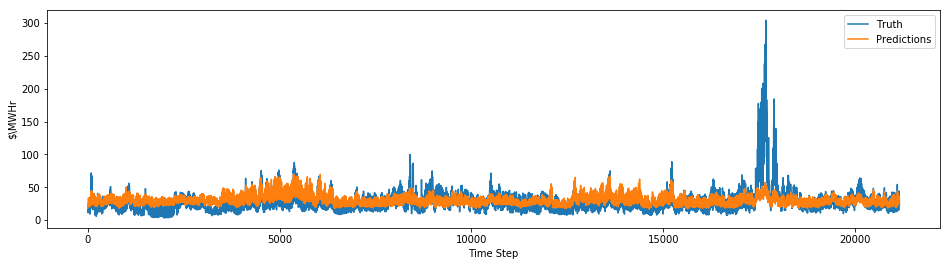

In [20]:
ax = train_df.plot(figsize=(16, 4))
ax.set_ylabel('$\MWHr')
ax.set_xlabel('Time Step')
plt.savefig('results/lstm-train.pdf')
plt.savefig('results/lstm-train.svg')

# Test Error

In [21]:
test_pred = model.predict(X_test).reshape(-1)

In [22]:
test_err = mean_squared_error(y_test * 1000, test_pred * 1000)
test_err

37.005321051469885

In [23]:
test_df = pd.DataFrame([y_test, test_pred], index=['Truth', 'Predictions']).T * 1000

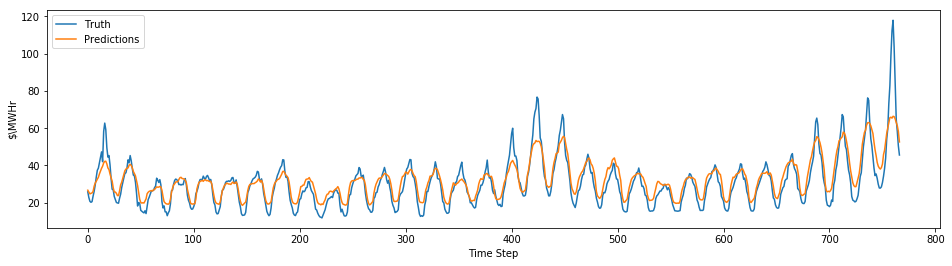

In [24]:
ax = test_df.plot(figsize=(16, 4))
ax.set_ylabel('$\MWHr')
ax.set_xlabel('Time Step')
plt.savefig('results/lstm-test.pdf')
plt.savefig('results/lstm-test.svg')

# Results

In [25]:
results = pd.Series([train_err, test_err], index=['Train', 'Test'])
results

Train    201.046126
Test      37.005321
dtype: float64

In [26]:
results.to_csv('results/lstm-mse.csv')